 # Flux comparison

 In FIG. 4 , the authors compared subsystems by selecting the most de-regulated reactions across cell types (LG and HG). I think They optimized to max biomass each of the 7 models  (they generated 7 FBA solutions) and then they computed the average of each flux across cell lines of the same family.



 However, they selected one of the many solutions that respect max biomass growth. I suggest to:



 1. Impose biomass at its upper bound for each model (LB = UB*0.90 to avoid solver numerical issues)

 2. Run flux sampling with OPTGP (cobrapy) with thinning = 100 and 1k samples per cell line

 3. DO not 'summarize' flux probability distributions with a simple average, but use more advanced methods. The objective here is to identify the most different reactions across the two cancer families. You could run non parametric statistical tests such as mann-whitney to check if two probability distributions are significantly different or not. You have 3 cells vs 2 cells (all pair combinations), so you could perform this test only on reactions belonging to core subsystems such as glycolysis, TCA cycle pentophosphate etc.. in order to redure the number of compared distribution per cell couple.

 4. Once you identified the top-n most different probability distributions (reaction fluxes) across cells of different type, you could plot them with boxplots as the authors did

 5. It might be interesting to check if we have 'less differences' in distributions of cells belonging to the same family.

In [1]:
from cobra.sampling import sample
import pandas as pd
import numpy as np
import pandas as pd
from cobra.io.json import load_json_model
import numpy as np
from cobra.flux_analysis import flux_variability_analysis
import os



In [2]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
model.objective = 'BIOMASS_reaction'


Set parameter Username
Set parameter LicenseID to value 2732830
Academic license - for non-commercial use only - expires 2026-11-04


 # Seperating reactions into pathways

In [3]:
subsystem_dict = {}

for r in model.reactions:
    # get subsystem safely
    s = (getattr(r, "subsystem", "") or "").strip()

    # if it contains "/", keep only the first part
    if "/" in s:
        s = s.split("/")[0].strip()   # take text before "/" and remove spaces

    s = s.lower()

    # skip empty subsystems
    if not s:
        continue

    # add reaction to that subsystem list
    subsystem_dict.setdefault(s, []).append(r.id)


In [4]:
# MODIFIED: Restricted keywords to only Glycolysis, TCA, and PPP
category_keywords = {
    "Glycolysis": [
        "glycolysis", "gluconeogenesis"
    ],
    
    "TCA": [
        "tca", "citric acid", "krebs", "tricarboxylic"
    ],
    
    "Pentose Phosphate Pathway": [
        "pentose phosphate", "ppp"
    ]
}


In [5]:
selected = {cat: [] for cat in category_keywords}


In [6]:
for subsystem_name, rxns in subsystem_dict.items():
    name_lower = subsystem_name.lower()

    for category, keywords in category_keywords.items():
        # Check if any keyword exists in the subsystem name
        if any(kw in name_lower for kw in keywords):
            # Use set to avoid duplicate reaction IDs if they appear in multiple subsystem variants
            selected[category].extend(rxns)


In [7]:
for cat, rxns in selected.items():
    # Using set() here ensures unique IDs count
    print(f"{cat}: {len(set(rxns))} reactions")


Glycolysis: 42 reactions
TCA: 20 reactions
Pentose Phosphate Pathway: 41 reactions


In [8]:
# Optional: Check specific reactions for one of the groups (e.g., TCA)
for rxn_id in list(set(selected["TCA"]))[:5]: # printing first 5 as example
    rxn = model.reactions.get_by_id(rxn_id)
    print(rxn_id, " → ", rxn.subsystem)


MDHm  →  Citric acid cycle
ACONTm  →  Citric acid cycle
ICDHym  →  Citric acid cycle
ALATA_Lm  →  Citric acid cycle
AKGDm  →  Citric acid cycle


In [9]:
# MODIFIED: Final dictionary only contains the 3 requested pathways
reactions_by_category = {
    "glycolysis": list(set(selected["Glycolysis"])),
    "tca": list(set(selected["TCA"])),
    "ppp": list(set(selected["Pentose Phosphate Pathway"]))
}

print("Categories created:", reactions_by_category.keys())

Categories created: dict_keys(['glycolysis', 'tca', 'ppp'])


## Flux sampling

In [10]:
low_grade = {
    'ACH-000520': '59M',
    'ACH-000542': 'HEYA8',
    'ACH-000091': 'OV56'
}
high_grade = {
    'ACH-000256': 'COV318',
    'ACH-000713': 'CAOV3',
    'ACH-000116': 'OAW28'
}


In [11]:
os.makedirs("data/flux_sampling_data_new", exist_ok=True)


In [12]:
def run_sampling_for_group(group_dict, suffix):
    for cl_id, cl_name in group_dict.items():
        print(f"\n=== Processing {cl_name} ({cl_id}) — {suffix} ===")

        # Load FVA file
        fva_path = f'./data/fva_rnaseq_{cl_id}_{suffix}.csv'
        df_fva = pd.read_csv(fva_path, index_col=0)

        # Clean invalid or missing bounds
        invalid = df_fva['minimum'] > df_fva['maximum']
        df_fva.loc[invalid, ['minimum', 'maximum']] = 0.0

        #  Inject reaction bounds into model
        for rxn_id, row in df_fva.iterrows():
            model.reactions.get_by_id(rxn_id).bounds = (row['minimum'], row['maximum'])

        # Check feasibility
        sol = model.optimize()
        print(f"   Status: {sol.status}, Growth: {sol.objective_value}")

        # Run flux sampling
        print("   Running OPTGP sampling...")
        samples = sample(model, n=1000, method="optgp", thinning=100, seed=42, processes= 2)

        # Save CSV
        out_path = f"./data/flux_sampling_data/flux_sampling_{suffix}_{cl_name}.csv"
        samples.to_csv(out_path)

        print(f"   Saved → {out_path}")


In [13]:
'''run_sampling_for_group(low_grade, "LG")
run_sampling_for_group(high_grade, "HG")'''


'run_sampling_for_group(low_grade, "LG")\nrun_sampling_for_group(high_grade, "HG")'

 # Flux Distribution comparisions

In [14]:
LG = {
    "59M": pd.read_csv("./flux_samples/ACH-000520.csv", index_col=0),
    "HEYA8": pd.read_csv("./flux_samples/ACH-000542.csv", index_col=0),
    "OV56" : pd.read_csv("./flux_samples/ACH-000091.csv", index_col=0)
}

HG = {
    "COV318": pd.read_csv("./flux_samples/ACH-000256.csv", index_col=0),
    "CAOV3": pd.read_csv("./flux_samples/ACH-000713.csv", index_col=0),
    "OAW28": pd.read_csv("./flux_samples/ACH-000116.csv", index_col=0)
}

In [15]:
import pandas as pd
import numpy as np
from itertools import combinations

# ==========================================
# PART 1: Identify "Stable" Reactions (FC Threshold)
# ==========================================
# We check if cell lines WITHIN the same group are similar.
# Requirement: Pairwise Fold Change must be < 0.2

stable_reactions = set()
stability_threshold = 0.50  # Max allowed difference (20%) within a group

# 1. Get all unique reactions
all_reactions = set()
for rxns in reactions_by_category.values():
    all_reactions.update(rxns)

print(f"Total reactions to check: {len(all_reactions)}")

def check_group_stability_fc(group_dict, rxn_name, threshold):
    """
    Returns True if the group is stable (Max pairwise Fold Change < threshold).
    Returns False if any pair differs by more than threshold.
    """
    # Collect valid means for this reaction per cell line
    line_means = {}
    for name, df in group_dict.items():
        if rxn_name in df.columns:
            vals = df[rxn_name].dropna()
            if len(vals) > 0:
                line_means[name] = vals.mean()
    
    names = list(line_means.keys())
    
    # If 0 or 1 cell line, it is stable by definition
    if len(names) < 2:
        return True

    # Check every pair (A vs B, A vs C...)
    for name1, name2 in combinations(names, 2):
        m1 = line_means[name1]
        m2 = line_means[name2]
        
        # Calculate Fold Difference
        # Avoid division by zero
        if m2 == 0:
            if m1 == 0: 
                fd = 0
            else: 
                fd = 1000 # Infinite difference (unstable)
        else:
            fd = abs((m1 - m2) / m2)
        
        # If ANY pair differs more than 0.2, the group is unstable
        if fd > threshold:
            return False

    return True

# Loop through all reactions and check stability
for rxn in all_reactions:
    is_lg_stable = check_group_stability_fc(LG, rxn, stability_threshold)
    is_hg_stable = check_group_stability_fc(HG, rxn, stability_threshold)
    
    # We enforce that BOTH groups must be internally stable to ensure
    # the final comparison (LG vs HG) is meaningful.
    if is_lg_stable and is_hg_stable:
        stable_reactions.add(rxn)

print(f"Reactions passing stability check (Internal FC < {stability_threshold}): {len(stable_reactions)}")

Total reactions to check: 103
Reactions passing stability check (Internal FC < 0.5): 17


 ## Automated version

In [16]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
results = []

# Iterate across all pathways
for pathway, reactions in reactions_by_category.items():

    for rxn in reactions:  # only reactions in this pathway
        if rxn not in stable_reactions:
            continue

        for lg_name, lg_df in LG.items():
            for hg_name, hg_df in HG.items():

                # extract distributions
                if rxn not in lg_df.columns or rxn not in hg_df.columns:
                    continue

                lg_values = lg_df[rxn].dropna()
                hg_values = hg_df[rxn].dropna()

                # skip empty
                if len(lg_values) == 0 or len(hg_values) == 0:
                    continue

                # compute means
                mean_lg = lg_values.mean()
                mean_hg = hg_values.mean()

                # Fold Difference FD = |(mean_lg - mean_hg) / mean_hg|
                if mean_hg == 0:
                    FD = np.nan
                else:
                    FD = abs((mean_lg - mean_hg) / mean_hg)

                # Mann-Whitney U test
                stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")

                results.append([
                    pathway, rxn, lg_name, hg_name,
                    stat, pval, mean_lg, mean_hg, FD
                ])

# Build DataFrame
df_stats = pd.DataFrame(results, columns=[
    "pathway", "reaction", "LG", "HG",
    "U_stat", "p_value", "mean_LG", "mean_HG", "fold_change"
])



In [17]:
# Collect all flux values for every reaction across LG + HG
reaction_flux_values = {}

for rxn in df_stats['reaction'].unique():
    values = []

    # Collect LG fluxes
    for lg_df in LG.values():
        if rxn in lg_df.columns:
            values.extend(lg_df[rxn].dropna().tolist())

    # Collect HG fluxes
    for hg_df in HG.values():
        if rxn in hg_df.columns:
            values.extend(hg_df[rxn].dropna().tolist())

    reaction_flux_values[rxn] = np.array(values)

ZERO_THRESHOLD = 1e-2

# Reactions that have ANY flux > threshold
nonzero_reactions = [
    rxn for rxn, vals in reaction_flux_values.items()
    if (np.mean(vals) > ZERO_THRESHOLD)
]


In [18]:
if df_stats.empty:
    print("No significant differences found or all reactions were filtered out.")
    top5_per_pathway = pd.DataFrame()
else:
    # 1. Multiple Testing Correction
    df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

    # 2. Filter for significant differences between LG and HG
    # Using your criteria: p_adj < 0.01 AND Fold Change > 0.90
    significant_pairs = df_stats[(df_stats["p_adjusted"] < 0.05)].copy()

    significant_pairs = significant_pairs[significant_pairs["reaction"].isin(nonzero_reactions)]


    if significant_pairs.empty:
        print("No pairs met the significance threshold (p<0.01, FC>0.9).")
        top5_per_pathway = pd.DataFrame()
    else:
        # 3. Group by Reaction to find the one with the highest AVERAGE Fold Change
        grouped_stats = (
            significant_pairs
            .groupby(["pathway", "reaction"])
            .agg(
                avg_fold_change=("fold_change", "mean"),
                avg_p_adj=("p_adjusted", "mean"),
                pair_count=("fold_change", "count")
            )
            .reset_index()
        )

        # 4. Select Top 5 per Pathway
        top5_per_pathway = (
            grouped_stats
            .sort_values(by="avg_fold_change", ascending=False)
            .groupby("pathway")
            .head(5)
            .reset_index(drop=True)
        )

        print("\nTop 5 Reactions per Pathway (Highest Avg Fold Change):")
        print(top5_per_pathway)


Top 5 Reactions per Pathway (Highest Avg Fold Change):
       pathway reaction  avg_fold_change      avg_p_adj  pair_count
0   glycolysis      FBA         0.366754   2.683740e-61           9
1   glycolysis      PFK         0.341863   2.571090e-07           8
2          ppp     TKT1         0.297406   8.099502e-04           9
3          ppp     TKT2         0.297406   8.099502e-04           9
4          tca    AKGDm         0.237070   2.190746e-13           8
5   glycolysis      PYK         0.196642   4.184647e-04           9
6          ppp      PPM         0.196558   4.981476e-03           6
7   glycolysis      TPI         0.186764  4.894376e-275           9
8          ppp     DRPA         0.175583   1.360550e-09           9
9          ppp     PPM2         0.174124   4.087866e-08           9
10  glycolysis     PGMT         0.172583  9.728791e-246           9


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

target_reactions = set(top5_per_pathway['reaction'])

# Create a mapping to know which pathway a reaction belongs to
# (Zip creates a dictionary: {'GNDer': 'ppp', 'ACITL': 'tca', ...})
rxn_to_pathway = dict(zip(top5_per_pathway.reaction, top5_per_pathway.pathway))

plot_data = []

# Collect Low Grade Data
for name, df in LG.items():
    for rxn in target_reactions:
        if rxn in df.columns:
            # Get all values, drop NaNs
            values = df[rxn].dropna().tolist()
            for v in values:
                plot_data.append({
                    "reaction": rxn,
                    "flux": v,
                    "Grade": "Low Grade",
                    "pathway": rxn_to_pathway[rxn],
                    "cell_line": name
                })

# Collect High Grade Data
for name, df in HG.items():
    for rxn in target_reactions:
        if rxn in df.columns:
            values = df[rxn].dropna().tolist()
            for v in values:
                plot_data.append({
                    "reaction": rxn,
                    "flux": v,
                    "Grade": "High Grade",
                    "pathway": rxn_to_pathway[rxn],
                    "cell_line": name
                })

# Create Long-Form DataFrame
df_plot = pd.DataFrame(plot_data)

In [20]:
glycolysis_dict = {
    "HEX1": "G → G6P",
    "PFK": "F6P → F1,6BP",
    "FBA": "F1,6BP → DHAP + GAP",
    "TPI": "DHAP → GAP",
    "GAPD": "GAP  → 1,3BPG "}

ppp_reaction_strings = {
    "PRPPS": "R5P + ATP -> PRPP + AMP",

    "TKT1": "X5P + R5P -> S7P + GAP",

    "TKT2": "X5P + E4P -> F6P + GAP",

    "PPM": "R1P -> R5P",

    "DRPA": "2DR5P -> GAP + Acetaldehyde"
}

tca_reaction_strings = {
    "ALATA_Lm": "Pyr + Glutamate\n→ Alanine + α-Ketoglutarate",

    "AKGDm": "α-Ketoglutarate + NAD+ + CoA\n→ Succinyl-CoA + NADH"
}

reaction_labels = {}
reaction_labels.update(glycolysis_dict)
reaction_labels.update(ppp_reaction_strings)
reaction_labels.update(tca_reaction_strings)


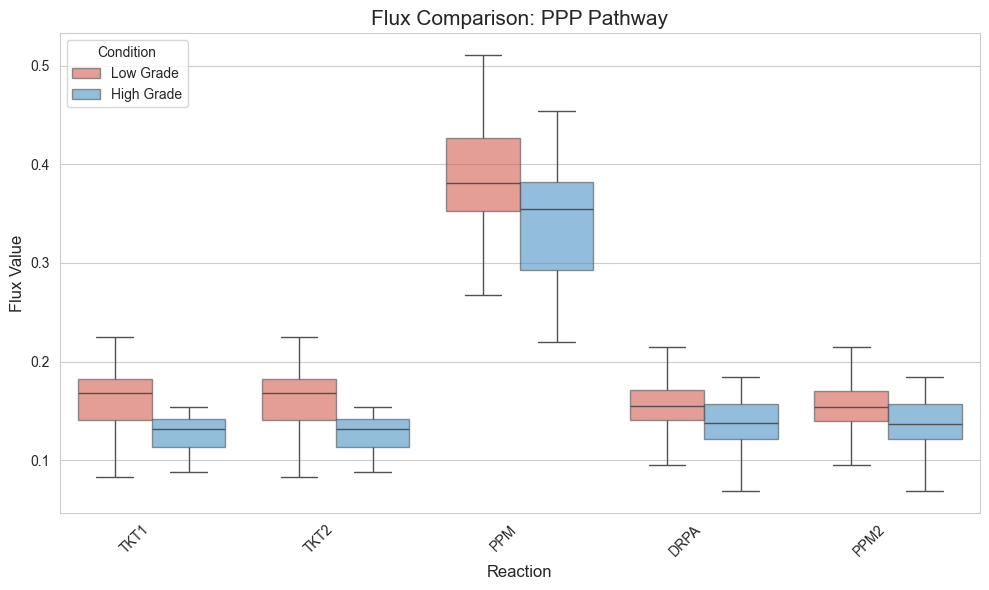

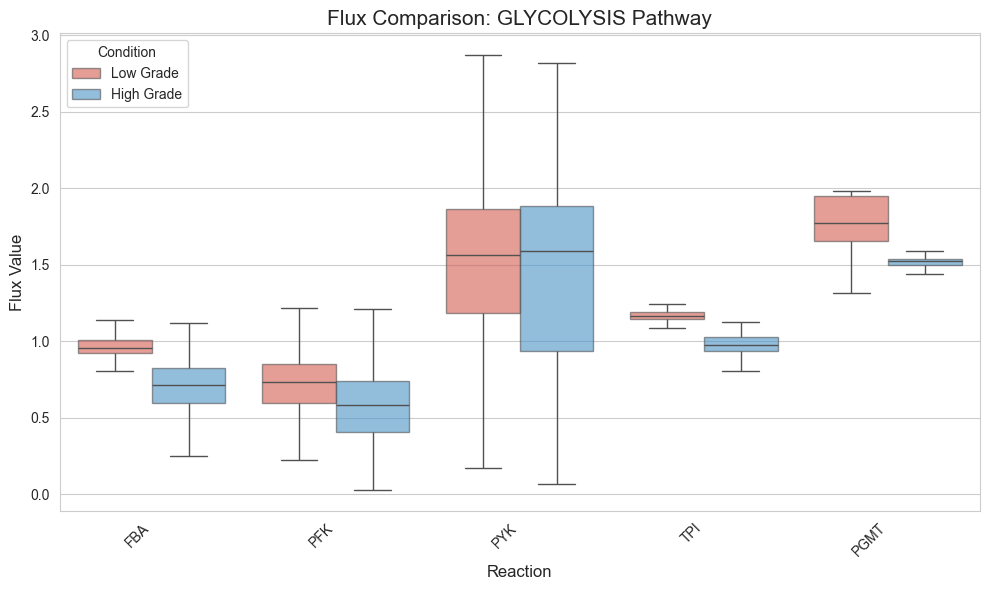

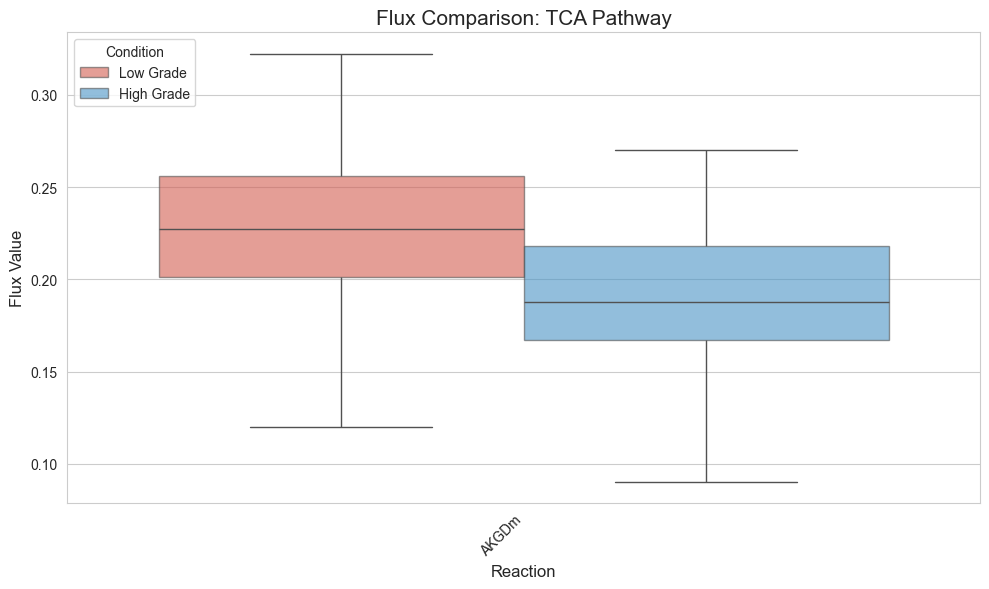

In [22]:
# Get list of unique pathways in your top 5 results
unique_pathways = df_plot['pathway'].unique()
#df_plot["reaction_label"] = df_plot["reaction"].map(reaction_labels)
# Set visual style
sns.set_style("whitegrid")

for pathway in unique_pathways:
    
    # Filter data for this pathway
    subset = df_plot[df_plot['pathway'] == pathway].copy()
    
    # Sort reactions by name or by magnitude if you prefer
    # Here we sort to match the order in top5_per_pathway if possible
    order_ids = top5_per_pathway[top5_per_pathway['pathway'] == pathway]['reaction'].tolist()
    #order_labels = [reaction_labels[r] for r in order_ids]
    
    # Initialize Figure
    plt.figure(figsize=(10, 6))
    
    # 1. Draw Boxplot
    ax = sns.boxplot(
        data=subset, 
        x='reaction', 
        y='flux', 
        hue='Grade',
        order=order_ids,
        palette={"Low Grade": "#e74c3c" , "High Grade": "#3498db" }, # Blue vs Red
        showfliers=False, # Hide outliers in boxplot (points show them anyway)
        boxprops={'alpha': 0.6} # Make boxes slightly transparent
    )
    
    
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Flux Comparison: {pathway.upper()} Pathway", fontsize=15)
    plt.ylabel("Flux Value", fontsize=12)
    plt.xlabel("Reaction", fontsize=12)
    
    # Clean up legend
    handles, labels = ax.get_legend_handles_labels()
    # We only want the first 2 handles (Boxplots), ignoring the extra handles from stripplot if any
    plt.legend(handles[:2], labels[:2], title="Condition", loc='upper left')
    
    
    plt.tight_layout()
    plt.show()

C:\Users\leabr\AppData\Local\Temp\ipykernel_48060\698775368.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\leabr\AppData\Local\Temp\ipykernel_48060\698775368.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


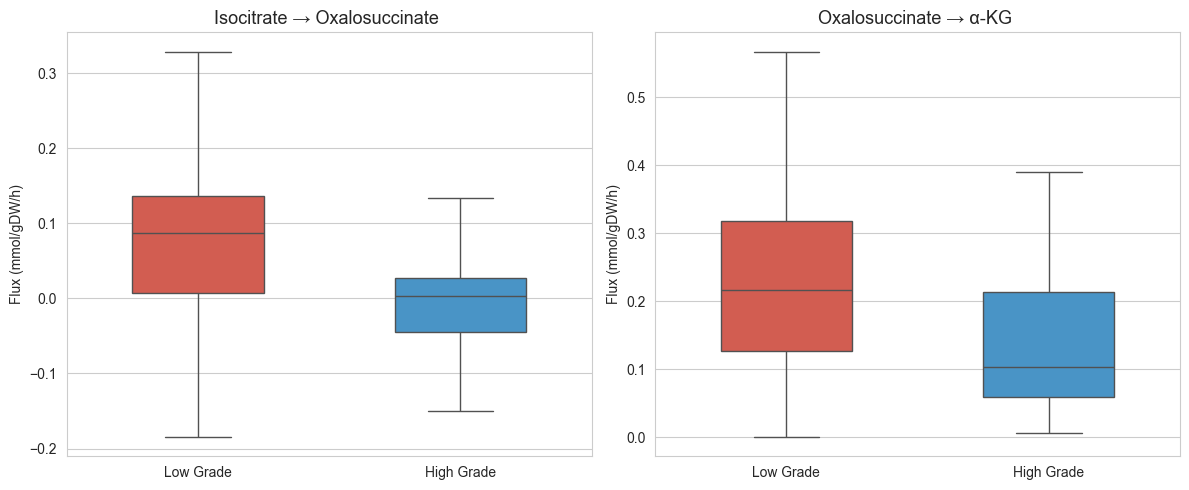

In [ ]:

# 1. Define reactions to plot
targets = ["r0425", "r0083"]
reaction_names = {
    "r0425": "Isocitrate → Oxalosuccinate ",
    "r0083": "Oxalosuccinate → α-KG " 
}

# 2. Collect Data
plot_data = []

def collect_flux(group_dict, grade_label):
    for cell_name, df in group_dict.items():
        for rxn in targets:
            if rxn in df.columns:
                vals = df[rxn].dropna().tolist()
                for v in vals:
                    plot_data.append({
                        "Reaction": rxn,
                        "Label": reaction_names.get(rxn, rxn),
                        "Flux": v,
                        "Grade": grade_label
                    })
            else:
                # Silent skip or simple print to avoid clutter if rxn missing in one cell line
                pass

collect_flux(LG, "Low Grade")
collect_flux(HG, "High Grade")

df_targets = pd.DataFrame(plot_data)

# 3. Plotting
if not df_targets.empty:
    sns.set_style("whitegrid")
    my_palette = {"Low Grade": "#e74c3c", "High Grade": "#3498db"}
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    
    # Loop through targets to plot on specific axes
    for ax, rxn in zip(axes, targets):
        # Subset data for this reaction
        subset = df_targets[df_targets["Reaction"] == rxn]
        
        if subset.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center')
            ax.set_title(rxn)
            continue
            
        sns.boxplot(
            data=subset,
            x="Grade",
            y="Flux",
            palette=my_palette,
            showfliers=False,
            width=0.5,
            ax=ax
        )
        
        ax.set_title(reaction_names.get(rxn, rxn), fontsize=13)
        ax.set_xlabel("")
        ax.set_ylabel("Flux (mmol/gDW/h)")
    
    plt.tight_layout()
    plt.show()

else:
    print("No flux data found for r0425 or r0083 in the provided dictionaries.")